# Comic Cluster

Ever wondered how clustring algorithms perform when you apply them to pictures?
Comics seem like a pretty good application of clustering algorithms:

- reduced set of colors
- color areas with lines in between

Readings:
- [An Introduction to Clustering Algorithms in Python](https://towardsdatascience.com/an-introduction-to-clustering-algorithms-in-python-123438574097)
- [The 5 Clustering Algorithms Data Scientists Need to Know](https://towardsdatascience.com/the-5-clustering-algorithms-data-scientists-need-to-know-a36d136ef68)


## Motivation
- I saw the [mandala app](https://play.google.com/store/apps/details?id=coloring.book.adults)
- I thought whey not use photos?
- I saw [coloring for kids](https://f-droid.org/en/packages/org.androidsoft.coloring/)


## Reading the image

In [90]:
# PARAMETER: use your own image
IMAGE_URL = "https://blog.schul-cloud.org/content/images/2018/08/Nicco-Kunzmann.jpg"
# PARAMETER: maybe use a local image?
image_path = None
#image_path = "mandala.jpg"

In [91]:
import tempfile, urllib, shutil
if not image_path:
    image_path = tempfile.mktemp(".jpg")
    with urllib.request.urlopen(IMAGE_URL) as response:
        with open(image_path, "wb") as f:
            shutil.copyfileobj(response, f)

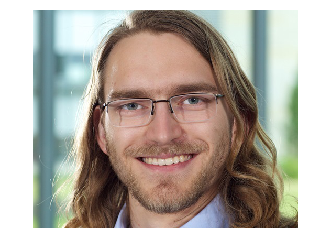

In [92]:
# this cell can be omitted
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image = mpimg.imread(image_path)
plt.imshow(image)
plt.axis('off')
plt.show()

## Transforming the Image

In [93]:
import numpy
print("image:\n", str(image)[:100])
reshaped_image = numpy.reshape(image, (len(image) * len(image[0]), len(image[0][0])))
print("reshaped:\n", str(reshaped_image)[:100])

image:
 [[[189 220 223]
  [183 214 217]
  [178 209 212]
  ..., 
  [236 249 240]
  [236 249 240]
  [236 249 2
reshaped:
 [[189 220 223]
 [183 214 217]
 [178 209 212]
 ..., 
 [ 61  51  39]
 [ 62  49  40]
 [ 70  57  48]]


## Clustering the image
Now, we cluster the points as described in [An Introduction to Clustering Algorithms in Python](https://towardsdatascience.com/an-introduction-to-clustering-algorithms-in-python-123438574097).


In [94]:
# PARAMETER: Use your own number of colors
NUMBER_OF_COLORS = 4

In [95]:
from sklearn.cluster import KMeans
# create kmeans object
kmeans = KMeans(n_clusters=NUMBER_OF_COLORS)
# fit kmeans object to data
kmeans.fit(reshaped_image)
# print location of clusters learned by kmeans object
print(kmeans.cluster_centers_)
# save new clusters for chart
y_km = kmeans.fit_predict(reshaped_image)

[[ 185.98092535  164.29083889  145.529338  ]
 [  75.39571551   53.06408431   42.33441836]
 [ 216.36120144  233.4166486   225.83625985]
 [ 128.50949832  121.13789028  109.64179936]]


## Color the image

We use a color palette from [digitalsynopsis](https://digitalsynopsis.com/design/beautiful-color-palettes-combinations-schemes/).

In [96]:
# use your own colors
COLOR_PALETTE = "#ee4035  #f37736  #fdf498  #7bc043  #0392cf"

In [97]:
color_palette = numpy.array([
    [int(color[i:i+2], 16) for i in (1, 3, 5)]
    for color in COLOR_PALETTE.split()
], numpy.uint8)
print(color_palette)

[[238  64  53]
 [243 119  54]
 [253 244 152]
 [123 192  67]
 [  3 146 207]]


In [98]:
colored_reshaped_image = color_palette[y_km]
print(colored_reshaped_image)

[[238  64  53]
 [238  64  53]
 [238  64  53]
 ..., 
 [243 119  54]
 [243 119  54]
 [243 119  54]]


In [99]:
comic = numpy.reshape(colored_reshaped_image, (len(image), len(image[0]), len(image[0][0])))
# ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64
# data type:
print(comic.dtype) 

uint8


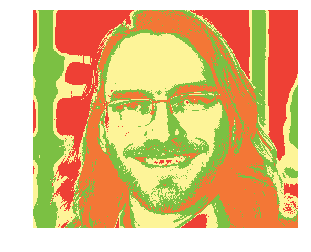

In [100]:
plt.imshow(comic)
plt.axis('off')
plt.show()

## removing the clutter

We use connected components to
1. cluster the points not only by color but also by being co-located
2. remove small clusters so the picture does not have so much clutter

Sources:
- [scipy lectures](https://scipy-lectures.org/packages/scikit-image/auto_examples/plot_labels.html)
- [set background!](https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.label)

In [101]:
from skimage import measure
image_colored = numpy.reshape(y_km, (len(image), len(image[0])))
all_labels = measure.label(image_colored, background=-1) - 1
print(all_labels)

[[   0    0    0 ...,   25   25   25]
 [   0    0    0 ...,   25   25   25]
 [   0    0    0 ...,   25   25   25]
 ..., 
 [1352 1352 1352 ...,    8    8    8]
 [1352 1352 1352 ...,    8    8    8]
 [1352 1352 1352 ...,    8    8    8]]


## finding the size of all clusters

Documentation:
- [w3resource](https://www.w3resource.com/python-exercises/numpy/python-numpy-stat-exercise-13.php)
- [array sort](https://stackoverflow.com/a/9008147/1320237)

In [102]:
component_sizes = numpy.bincount(all_labels.flatten()) 
print(component_sizes)

[  548   482 15850 ...,     1     1     1]


In [103]:
sorted_component_size_indices = component_sizes.argsort()
print(sorted_component_size_indices)

[713 751 752 ..., 443   4   8]


## Removing components starting from smallest

In [104]:
# change the number of areas you would like to color
NUMBER_OF_AREAS = 30

In [105]:
ALL_COMPONENTS_ADDED = component_sizes.sum()
DELETED_COMPONENT_VALUE = ALL_COMPONENTS_ADDED + 1 # use big value so we still work on the small ones

# copy the contents so this is reproducible
unified_labels = all_labels.copy()
unified_component_sizes = component_sizes.copy()

for i in range(len(sorted_component_size_indices) - NUMBER_OF_AREAS):
    component_id = unified_component_sizes.argmin()
    #print("component {} has {} elements".format(component_id, unified_component_sizes[component_id]))
    x, y = numpy.where(unified_labels == component_id)
    # use -1,-1 as offset because that makes it easy to check bounds with abs
    # possible enhancement is to compute all directions
    neighbor_components = numpy.concatenate((
            unified_labels[abs(x - 1), abs(y - 1)],
            unified_labels[x, abs(y - 1)],
            unified_labels[abs(x - 1), y]))
    #print("neighbor_components:", neighbor_components)
    neighbor_sizes = numpy.bincount(neighbor_components)
    #print("neighbor_sizes:", neighbor_sizes)
    if component_id in neighbor_components:
        neighbor_sizes[component_id] = 0 # delete the component itself because it should be deleted
    biggest_neighbor_id = neighbor_sizes.argmax()
    print("merging {}\tinto {}".format(component_id, biggest_neighbor_id))
    # replace it
    unified_component_sizes[biggest_neighbor_id] += unified_component_sizes[component_id]
    assert unified_component_sizes[biggest_neighbor_id] < DELETED_COMPONENT_VALUE, "a deleted component should never be merged!"
    unified_component_sizes[component_id] = DELETED_COMPONENT_VALUE
    unified_labels[numpy.where(unified_labels == component_id)] = biggest_neighbor_id
    assert unified_component_sizes.sum() == ALL_COMPONENTS_ADDED + (i + 1) * DELETED_COMPONENT_VALUE, "{} == {}".format(component_sizes.sum(), ALL_COMPONENTS_ADDED + i * DELETED_COMPONENT_VALUE)

merging 7	into 6
merging 9	into 8
merging 15	into 14
merging 17	into 16
merging 21	into 20
merging 27	into 8
merging 28	into 20
merging 29	into 8
merging 30	into 16
merging 31	into 8
merging 32	into 8
merging 33	into 8
merging 34	into 16
merging 36	into 8
merging 37	into 8
merging 41	into 16
merging 43	into 8
merging 45	into 8
merging 46	into 20
merging 50	into 8
merging 52	into 20
merging 54	into 8
merging 55	into 8
merging 58	into 8
merging 60	into 16
merging 61	into 19
merging 62	into 19
merging 63	into 8
merging 64	into 8
merging 68	into 20
merging 69	into 8
merging 70	into 8
merging 71	into 8
merging 72	into 8
merging 74	into 8
merging 81	into 8
merging 82	into 16
merging 83	into 4
merging 84	into 8
merging 85	into 8
merging 91	into 6
merging 96	into 4
merging 97	into 8
merging 98	into 8
merging 102	into 93
merging 104	into 6
merging 106	into 6
merging 107	into 6
merging 109	into 6
merging 111	into 6
merging 113	into 5
merging 114	into 8
merging 115	into 8
merging 116	into 8
mergi

merging 1007	into 8
merging 1011	into 4
merging 1013	into 439
merging 1014	into 439
merging 1016	into 443
merging 1017	into 8
merging 1019	into 287
merging 1025	into 443
merging 1027	into 439
merging 1028	into 439
merging 1033	into 296
merging 1035	into 296
merging 1037	into 8
merging 1039	into 3
merging 1043	into 439
merging 1044	into 443
merging 1045	into 443
merging 1048	into 8
merging 1050	into 4
merging 1057	into 439
merging 1058	into 8
merging 1062	into 439
merging 1067	into 8
merging 1070	into 439
merging 1071	into 439
merging 1073	into 8
merging 1075	into 439
merging 1076	into 296
merging 1079	into 8
merging 1080	into 8
merging 1081	into 8
merging 1083	into 296
merging 1084	into 8
merging 1087	into 296
merging 1089	into 439
merging 1091	into 439
merging 1092	into 8
merging 1095	into 8
merging 1097	into 439
merging 1101	into 439
merging 1104	into 439
merging 1109	into 443
merging 1111	into 287
merging 1112	into 991
merging 1115	into 8
merging 1117	into 991
merging 1129	into 439


merging 281	into 6
merging 301	into 16
merging 305	into 16
merging 312	into 142
merging 328	into 313
merging 351	into 6
merging 361	into 352
merging 374	into 8
merging 377	into 268
merging 384	into 8
merging 393	into 8
merging 417	into 8
merging 418	into 8
merging 448	into 341
merging 451	into 8
merging 452	into 142
merging 486	into 341
merging 497	into 23
merging 502	into 6
merging 506	into 341
merging 509	into 441
merging 510	into 463
merging 522	into 341
merging 531	into 8
merging 532	into 296
merging 536	into 527
merging 538	into 341
merging 539	into 443
merging 557	into 443
merging 561	into 4
merging 580	into 23
merging 605	into 443
merging 614	into 589
merging 616	into 24
merging 641	into 439
merging 682	into 634
merging 697	into 471
merging 700	into 636
merging 708	into 439
merging 715	into 2
merging 732	into 471
merging 735	into 23
merging 736	into 2
merging 742	into 471
merging 759	into 471
merging 765	into 595
merging 772	into 23
merging 775	into 471
merging 776	into 471
merg

merging 1332	into 296
merging 224	into 4
merging 990	into 586
merging 782	into 471
merging 533	into 443
merging 480	into 8
merging 339	into 4
merging 956	into 8
merging 5	into 4
merging 1237	into 296
merging 455	into 288
merging 634	into 8
merging 1100	into 439
merging 463	into 341
merging 93	into 4
merging 589	into 8
merging 432	into 407
merging 599	into 439
merging 649	into 23
merging 915	into 287
merging 595	into 586
merging 1094	into 439
merging 268	into 23
merging 352	into 8
merging 1	into 0
merging 1061	into 287


In [106]:
remaining_components = unified_component_sizes != DELETED_COMPONENT_VALUE
components_left = numpy.where(remaining_components)[0]
print("components left with size:\n",
      numpy.array((components_left, unified_component_sizes[components_left])))
print("full size:", unified_component_sizes[components_left].sum(), len(unified_labels) * len(unified_labels[0]), ALL_COMPONENTS_ADDED)
assert unified_component_sizes[components_left].sum() == ALL_COMPONENTS_ADDED == len(unified_labels) * len(unified_labels[0])

rerun_components = measure.label(unified_labels)
print(rerun_components)

components left with size:
 [[    0     2     3     4     6     8    16    19    20    23    24    25
    141   142   287   288   296   323   341   407   439   443   471   586
    839   861   991  1153  1255  1343]
 [ 1030 16053  6375 21541  4962 34762  2562  1421  6022  9523  1644 12183
   1091 17003  6189   785 14056  1526  2260   927 13390 19534  6953  1145
    846   694  1343  2948   886   842]]
full size: 210496 210496 210496
[[ 0  0  0 ..., 11 11 11]
 [ 0  0  0 ..., 11 11 11]
 [ 0  0  0 ..., 11 11 11]
 ..., 
 [ 1  1  1 ...,  5  5  5]
 [ 1  1  1 ...,  5  5  5]
 [ 1  1  1 ...,  5  5  5]]


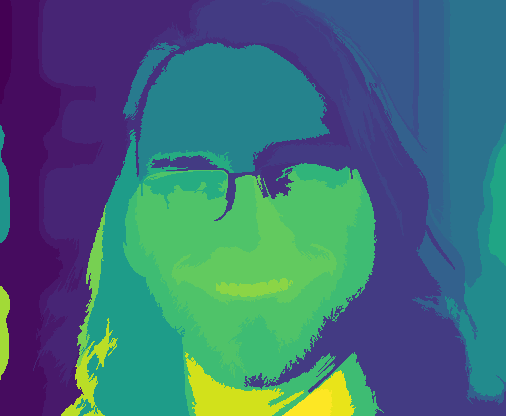

In [107]:
from IPython.core.display import Image, display
image_path2 = tempfile.mktemp(".png")
# thanks to https://stackoverflow.com/a/21464691/1320237
mpimg.imsave(image_path2, rerun_components)
# thanks to https://stackoverflow.com/a/32370538/1320237
display(Image(filename = image_path2, unconfined=True))

## create borders around the areas

For this, we move them an see the places where the components differ.
In these places, we make it white.


In [108]:
## Helpers
a = numpy.array([[1,2,3,0], [4,5,6,0], [7,8,9,0]])
print(a)
a_x = numpy.insert(a, len(a[0]), [11,11,11], 1).reshape((3, 5))
print(a_x)
a_y = numpy.insert(a, 4*3, [11,11,11,11]).reshape((4, 4))
print(a_y)
print(numpy.roll(a_x, 1))
print(numpy.roll(a_y, 1, 0))

[[1 2 3 0]
 [4 5 6 0]
 [7 8 9 0]]
[[ 1  2  3  0 11]
 [ 4  5  6  0 11]
 [ 7  8  9  0 11]]
[[ 1  2  3  0]
 [ 4  5  6  0]
 [ 7  8  9  0]
 [11 11 11 11]]
[[11  1  2  3  0]
 [11  4  5  6  0]
 [11  7  8  9  0]]
[[11 11 11 11]
 [ 1  2  3  0]
 [ 4  5  6  0]
 [ 7  8  9  0]]


### rotate the image to compare

In [109]:
#unified_labels_x = (numpy.insert(
#        unified_labels, 
#        len(unified_labels[0]),
#        numpy.zeros(len(unified_labels), unified_labels.dtype),
#        1)
#    .reshape((len(unified_labels), len(unified_labels[0]) + 1)))
#unified_labels_y = (numpy.insert(
#        unified_labels, 
#        len(unified_labels[0]) * len(unified_labels),
#        numpy.zeros(len(unified_labels[0]), unified_labels.dtype))
#    .reshape((len(unified_labels)  + 1, len(unified_labels[0]))))
unified_labels_x = unified_labels
unified_labels_y = unified_labels
unified_labels_x_to_right = numpy.roll(unified_labels_x, 1)
unified_labels_y_to_bottom = numpy.roll(unified_labels_y, 1, 0)

### compare the image

Inspiration: https://stackoverflow.com/a/29488679/1320237

In [110]:
image_with_borders = numpy.zeros((len(unified_labels_x), len(unified_labels_x[0])), numpy.uint8)
image_with_borders[unified_labels_x != unified_labels_x_to_right] = True
#image_with_borders_y = numpy.zeros((len(unified_labels_y), len(unified_labels_y[0])), numpy.uint8)
image_with_borders[unified_labels_y != unified_labels_y_to_bottom] = True

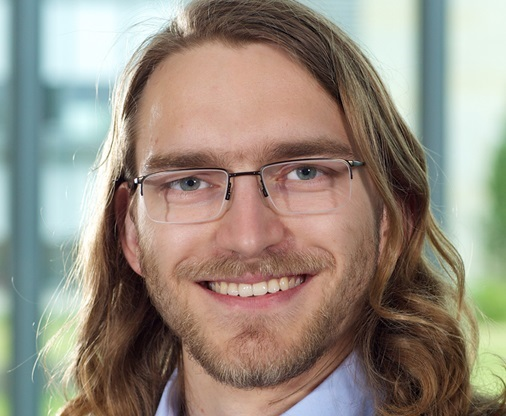

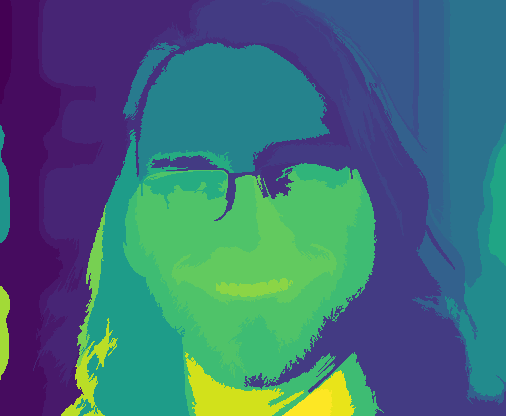

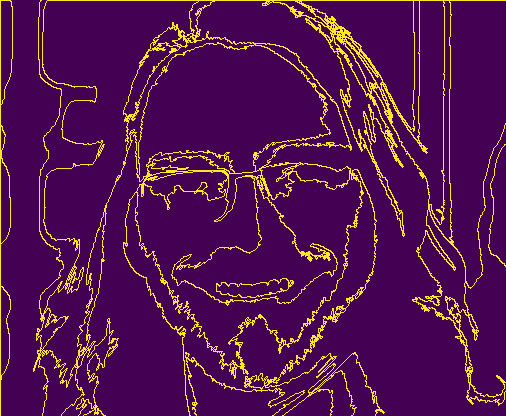

Number of Areas: 30


In [111]:
from IPython.core.display import Image, display
image_path3 = tempfile.mktemp(".png")
# thanks to https://stackoverflow.com/a/21464691/1320237
mpimg.imsave(image_path3, image_with_borders)
# thanks to https://stackoverflow.com/a/32370538/1320237
for image_path_ in [image_path, image_path2, image_path3]:
    display(Image(filename = image_path_, unconfined=True))
print("Number of Areas:", NUMBER_OF_AREAS)

## Summary

It is possible, with simple algorithms, to create comic illustrations and also to make pictures for mandala color books!